In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle as pkl
import sys

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

import torch.utils.data as data 
import torch
from torch_geometric.data import Data
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch.utils.data import Dataset, DataLoader

import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import NeighborLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import MessagePassing, SAGEConv
from ogb.nodeproppred import Evaluator #PygNodePropPredDatase

from IPython.display import clear_output


from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F



In [2]:
# Read files
path = "C:/Users/gsamp/OneDrive/Documents/AI-3/2n Semestre/Projecte de Síntesi 2/GraphAnomaly/dades_guillem/"
df_train = pd.read_csv(path + "train_set.csv") 
df_test = pd.read_csv(path + "test_set.csv")
df_train_edges = pd.read_csv(path + "train_edges.csv")
df_test_edges = pd.read_csv(path + "test_edges.csv")

In [3]:
# AIXO JA NO HAURIA DE CALDRE, ESTA AL DATA SPLIT
# path = "C:/Users/gsamp/OneDrive/Documents/AI-3/2n Semestre/Projecte de Síntesi 2/GraphAnomaly/dades_guillem/"
# df_classes = pd.read_csv(path + "elliptic_txs_classes.csv") # Nodes' labels
# df_edges_init = pd.read_csv(path + "elliptic_txs_edgelist.csv") # Edges
# df_features = pd.read_csv(path + "elliptic_txs_features.csv", header=None) # Nodes' features

# # Change column names of df_features
# colNames1 = {'0': 'txId', 1: "Time step"}
# colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
# colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

# colNames = dict(colNames1, **colNames2, **colNames3 )
# colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

# df_features = df_features.rename(columns=colNames)

In [4]:
def prep_df(feats: pd.DataFrame, edges: pd.DataFrame):
    #1 és la classe illicit, 2 la  licit
    df_feats = feats.loc[feats['class'].isin([1, 2, 3])]
    df_feats['class'] = df_feats['class'].replace({1: 0, 2: 1})
    df_feats = df_feats.reset_index(drop=True)

#     #ens quedem només amb els edges que apareixen en el nodes que estan en el dataset
#     df_edges = edges.loc[((edges['txId1'].isin(df_feats['txId'])) & (df_edges_init['txId2'].isin(df_feats['txId'])))]
#     df_edges = df_edges.reset_index(drop=True)
#     print(f"contador de valors per classe: \n {df_feats['class'].value_counts()}\n")
#     return  df_feats, df_edges

# df_train, df_edges_train = prep_df(df_train_init, df_edges_init)
# df_test, df_edges_test = prep_df(df_test_init, df_edges_init)

contador de valors per classe: 
 class
3    123281
1     34654
0      2672
Name: count, dtype: int64

contador de valors per classe: 
 class
3    33924
1     7365
0     1873
Name: count, dtype: int64



In [5]:
def map_idx(feats: pd.DataFrame, edges: pd.DataFrame, save = True, loading_dir = "a"):
    mapping_txid = dict(zip(feats['txId'], list(feats.index)))
    dir = 'dades_guillem/' + str(loading_dir) + '.pkl'
    if save:
        df_edges_mapped = edges.replace({'txId1': mapping_txid, 'txId2': mapping_txid})
        
        df_edges_mapped.to_pickle(loading_dir)
    else:
        df_edges_mapped = pd.read_pickle(loading_dir)
    return df_edges_mapped

df_edges_mapped_train = map_idx(feats = df_train, edges = df_train_edges, save = True, loading_dir='train')
df_edges_mapped_test = map_idx(feats = df_test, edges = df_train_edges, save = True, loading_dir='train')


In [ ]:
def get_data(feats: pd.DataFrame, edges:pd.DataFrame):
    x = torch.tensor(feats.drop(columns=['class', 'Time Step', 'txId']).values, dtype=torch.float)
    edge_index = torch.tensor(edges.values, dtype=torch.long).T
    y = torch.tensor(feats['class'].values)
    time = torch.tensor(feats['Time Step'].values)
    data = Data(x=x, edge_index=edge_index, y=y, time=time)
    return data


train_data = get_data(df_train, df_edges_mapped_train)
test_data = get_data(df_test, df_edges_mapped_test)

Prepare data for the AE case

In [ ]:
#separate illicit and licit data
def separate_data(feats):
    licit_x = torch.tensor(feats.loc[feats['class'] == 1].drop(columns=['class', 'Time Step']).values, dtype=torch.float)
    licit_y = torch.tensor(feats.loc[feats['class'] == 1]['class'].values)
    licit_data = Data(x=licit_x, y=licit_y)

    illicit_x = torch.tensor(feats.loc[feats['class'] == 0].drop(columns=['class', 'Time Step']).values, dtype=torch.float)
    illicit_y = torch.tensor(feats.loc[feats['class'] == 0]['class'].values)
    illicit_data = Data(x=illicit_x, y=illicit_x)
    return licit_data, illicit_data

train_licit, train_illicit = separate_data(df_train)
test_licit, test_illicit = separate_data(df_test)    

In [ ]:
unk_x = torch.tensor(df_test.loc[df_test['class'] == 3].drop(columns=['class', 'Time Step']).values, dtype=torch.float)
unk_y = torch.tensor(df_test.loc[df_test['class'] == 3]['class'].values)
unk_data = Data(x=unk_x, y=unk_y)
unk_data

Data(x=[33924, 166], y=[33924])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(sample, dtype=torch.float32)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=50):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.Tanh(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, input_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
def train_ae(autoencoder, data_loader, criterion, optimizer, val_loader, num_epochs=10, learning_rate=0.001):   
    total_train_loss = [] 
    total_validation_loss = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in data_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = autoencoder(inputs)
            
            # Compute the loss
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        train_loss = running_loss / len(data_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")
        total_train_loss.append(train_loss)
        
        #validació dins del mateix train loop
        validation_loss = val_ae(autoencoder=autoencoder, data_loader=val_loader, criterion=criterion)
        print(f"Validation Loss: {validation_loss:.4f}")
        total_validation_loss.append(validation_loss)
    return total_train_loss, total_validation_loss

def val_ae(autoencoder, data_loader, criterion):
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = autoencoder(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    epoch_loss = val_loss / len(data_loader.dataset)
    return epoch_loss


In [ ]:
batch_size = 128

#samplejar només n elements de les lícites per entrenar el AE
x_train = torch.tensor(df_train.loc[df_train["class"] == 1].drop(columns=['class', 'txId', 'Time Step']).values)

# n = int(x.shape[0] * 0.2)
# x_train = x[n:]
x_val = torch.tensor(df_test.loc[df_test["class"] == 1].drop(columns=['class', 'txId', 'Time Step']).values)
print(x_train.shape)
#amb el scaler la loss passe de 4 a 0.1
# train_data = preprocessing.MinMaxScaler().fit_transform(x_train)
# val_data = preprocessing.MinMaxScaler().fit_transform(x_val)

# train_data, val_data = train_test_split(x, test_size=0.2, random_state=42)

train_dataset = CustomDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

torch.Size([34654, 165])


In [ ]:
#hiperparàmetres
lr = 0.001
EPOCHS = 250

input_dim = x_train.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)



# training_loss, validation_loss = train_ae(autoencoder=model, data_loader=train_loader, criterion=criterion, 
#                                           optimizer=optimizer, val_loader=val_loader, num_epochs=EPOCHS, learning_rate=lr)
# torch.save(model.state_dict(), 'C:/Users/gsamp/OneDrive/Documents/AI-3/2n Semestre/Projecte de Síntesi 2/GraphAnomaly/GNN_models/trained_models/ae_new_data.pth')

Error de recunstrucció

In [ ]:
torch.tensor(df_test.loc[df_test["class"] == 3].drop(columns=['class', 'txId', 'Time Step']).values).shape

torch.Size([33924, 165])

In [ ]:
# Define the path to the saved model
model_path = "C:/Users/gsamp/OneDrive/Documents/AI-3/2n Semestre/Projecte de Síntesi 2/GraphAnomaly/GNN_models/trained_models/ae_new_data.pth"

# Create an instance of your model
model = Autoencoder(input_dim)

# Load the state_dict into the model
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()


ilicit_data = torch.tensor(df_test.loc[df_test["class"] == 0].drop(columns=['class', 'txId', 'Time Step']).values)
# ilicit_data = preprocessing.MinMaxScaler().fit_transform(ilicit_data)
ilicit_dataset = CustomDataset(ilicit_data)
ilicit_loader = DataLoader(ilicit_dataset, batch_size=batch_size, shuffle=True)

unk_data = torch.tensor(df_test.loc[df_test["class"] == 3].drop(columns=['class', 'txId', 'Time Step']).values)
# unk_data = preprocessing.MinMaxScaler().fit_transform(unk_data)
unk_dataset = CustomDataset(unk_data)
unk_loader = DataLoader(unk_dataset, batch_size=batch_size, shuffle=True)

# Initialize variables for storing reconstruction error
total_licit_loss = 0
total_ilicit_loss = 0
total_unk_loss = 0

num_batches = 0

licit_loss_history = []
ilicit_loss_history = []
unk_loss_history = []

# Iterate through the validation dataset
with torch.no_grad():
    # for seen, unseen, unk in zip(val_loader, ilicit_loader, unk_loader):
    for unseen in ilicit_loader:   
        # seen_inputs, _ = seen
        unseen_inputs, _ = unseen
        # unk_inputs, _ = unk
        
        # seen_outputs = model(seen_inputs)
        unseen_outputs = model(unseen_inputs)
        # unk_outputs = model(unk_inputs)
        
        # seen_loss = criterion(seen_outputs, seen_inputs)  # Compute reconstruction loss
        unseen_loss = criterion(unseen_outputs, unseen_inputs)
        # unk_loss = criterion(unk_outputs, unk_inputs)
        
        # licit_loss_history.append(float(seen_loss))
        ilicit_loss_history.append(float(unseen_loss))
        # unk_loss_history.append(float(unk_loss))
        
        # total_licit_loss += seen_loss.item()
        total_ilicit_loss += unseen_loss.item()
        # total_unk_loss += unk_loss.item()
        num_batches += 1

# Compute average reconstruction error for both seen and unseen classes
# average_licit_loss = total_licit_loss / num_batches
average_ilicit_loss = total_ilicit_loss / num_batches
# average_unk_loss = total_unk_loss / num_batches

# print("Average Reconstruction Error for Licit Class:", average_licit_loss)
print("Average Reconstruction Error for Illicit Class:", average_ilicit_loss)
# print("Average Reconstruction Error for Unk Class:", average_unk_loss)

# You can return ilicit_loss_history if you want to analyze it further


Average Reconstruction Error for Illicit Class: 0.062148159742355345


In [ ]:
def infer_AE(loader, model):

    total_loss = 0
    num_batches = 0

    loss_history = []

    # Iterate through the validation dataset
    with torch.no_grad():
        for input in loader:
            
            inputs, _ = input
            
            outputs = model(inputs)
            
            loss = criterion(outputs, inputs)  # Compute reconstruction loss
            
            loss_history.append(float(loss))
            
            total_loss += loss.item()
            num_batches += 1
            
            #avergade loss, loss_history
    average_loss = total_loss / num_batches
    return average_loss, loss_history

# Define the path to the saved model
model_path = "C:/Users/gsamp/OneDrive/Documents/AI-3/2n Semestre/Projecte de Síntesi 2/GraphAnomaly/GNN_models/trained_models/ae_new_data.pth"

# Create an instance of your model
model = Autoencoder(input_dim)

# Load the state_dict into the model
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

unk_avg_loss, unk_loss_history = infer_AE(unk_loader, model)
val_avg_loss, licit_loss_history = infer_AE(val_loader, model)
ilicit_avg_loss, ilicit_loss_history = infer_AE(ilicit_loader, model)

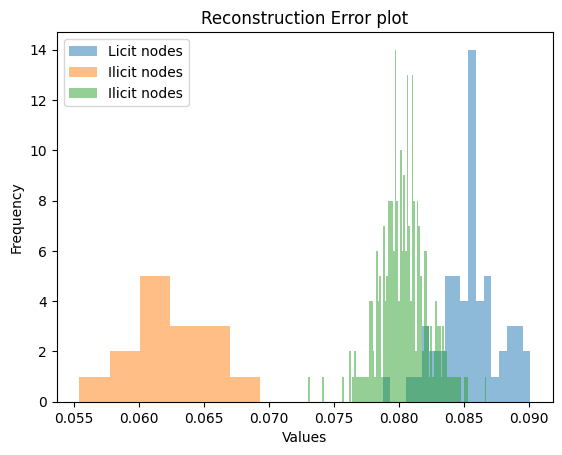

In [ ]:
import matplotlib.pyplot as plt

# Determine the range of values in both lists
min_value = min(min(licit_loss_history), min(ilicit_loss_history), min(unk_loss_history))
max_value = max(max(licit_loss_history), max(ilicit_loss_history), max(unk_loss_history))

# Plot histograms for both lists with 10 bins
plt.hist(licit_loss_history, bins=len(licit_loss_history), alpha=0.5, label='Licit nodes', range=(min_value, max_value))
plt.hist(ilicit_loss_history, bins=len(ilicit_loss_history), alpha=0.5, label='Ilicit nodes', range=(min_value, max_value))
plt.hist(unk_loss_history, bins=len(unk_loss_history), alpha=0.5, label='Unknown nodes', range=(min_value, max_value))

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Reconstruction Error plot')

# Add legend
plt.legend()

# Show the plot
plt.show()
